# Computer Vision Coursework Submission (IN3060/INM460)

**Student name, ID and cohort:** Archie Short (190005661) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [57]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Archie_Short_CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'Personal_Dataset', 'Models', 'CW_Dataset', 'Code', 'test_functions.ipynb']


### Load packages 

In the next cell you should load all the packages required to test your functions.

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import keras
import random
import cv2
import os
import os.path
from scipy.signal import gaussian, convolve2d,wiener
from numpy.fft import fft2, ifft2
from skimage import color
from skimage.transform import resize
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import re


### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `EmotionRecognition` to avoid having to reload them each time.

In [59]:
hog_lbp_rsvm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','RSVM.joblib'))
hog_lbp_rf = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','random_forest.joblib'))
hog_lbp_cnn = keras.models.load_model(os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_Model'))

### Define EmotionRecognition

Here all the code required to run EmotionRecognition is held. This includes the preprocessing and feature extraction required for the images to be predicted.


For my get_folder_labels I followed this forum post on how to get an expression that gives the last number in a string https://stackoverflow.com/questions/33545863/python-find-position-of-last-digit-in-string it also gets used again in my emotion detection function



In [60]:
LABEL_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/labels')
TEST_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/test')
#reference https://www.researchgate.net/figure/Wiener-Filter-implementation-using-Python_fig3_332574579  
#These are functions needed for the preprocessing of images 
def gaussian_kernal(kernel_size =3):
  h = gaussian(kernel_size,kernel_size/3).reshape(kernel_size,1) 
  h = np.dot(h,h.transpose())
  h /= np.sum(h) 
  return h 

def wiener_filter(img,kernel,k):
  kernel /= np.sum(kernel)
  dummy = np.copy(img)
  dummy = fft2(dummy)
  kernel = fft2(kernel, s=img.shape)
  kernel = np.conj(kernel) / (np.abs(kernel)**2 + k)
  dummy = dummy * kernel
  dummy = np.abs(ifft2(dummy))
  return dummy 

#This function is used to get the lables of the images 


def get_folder_labels(path):
  image_labels = {}
  folder_name = os.path.basename(path)
  labels_filename = "list_label_"+folder_name+".txt"
  with open(os.path.join(LABEL_FOLDER,labels_filename),'r') as f:
    for line in f:
      #reference https://stackoverflow.com/questions/33545863/python-find-position-of-last-digit-in-string
      (filename,label) = line.split()
      s = filename[::-1]
      m = re.search('\d', s)
      pos = len(s) - m.start(0)
      image_labels[str(filename[:pos])] = int(label)
  f.close()
  return image_labels



In [61]:
#Facial detection for in the wild images 
#Reference for implementation https://www.geeksforgeeks.org/cropping-faces-from-images-using-opencv-python/

def locateFace(image):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_alt2.xml')
  image_gray  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(image_gray, 1.1, 4)
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h),(0, 0, 255), 2)
    faces = image_gray[y:y + h, x:x + w]
  return image,faces


In [62]:
def EmotionRecognition(path, model):
  #load in 4 random images from path
  images = []
  show_images = []
  true_labels = []
  folder_labels = {}

  #load in all the image names and labels for the selected folder
  try:
    folder_labels = get_folder_labels(path)
  except Exception as e:
    print(e)
    print("There is no file in labels matching the folder")
  
  #choose 4 images and load them into two arrays, one for colour thatll get shown
  #at the end and another one to be fed into the pipeline
  while len(images) <= 3:
    file = random.choice(os.listdir(path))
    image_path= os.path.join(path, file)
    try:
      img_array = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
      img_array_colour = cv2.imread(image_path)
      if(img_array_colour.shape[0] > 100 or img_array_colour.shape[1] > 100 ):
        im_to_show,face = locateFace(img_array_colour)
        images.append(face)
        show_images.append(im_to_show)
      else:
        images.append(img_array)
        show_images.append(img_array_colour)
#reference https://stackoverflow.com/questions/33545863/python-find-position-of-last-digit-in-string

      s = file[::-1]
      m = re.search('\d', s)
      pos = len(s) - m.start(0)
      true_labels.append(folder_labels[file[:pos]])
    except Exception as e:
      print(e)
    
 
  featureVectors = []
  #Preprocess and extract features
  for image in images:
    #resize for smaller data, makes it quicker to train and compute
    #without loss of detail
    resized_image = cv2.resize(image, (70, 70)) 

    #Equalise the image exposure, this helps with the feature extraction making darker
    #images more readable
#reference https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html  

    equalisedImage = cv2.equalizeHist(resized_image)

    #Smooth noise with Wiener
    kernel = gaussian_kernal(4)
    wienerImage = wiener_filter(equalisedImage,kernel,k=5)
#reference https://fairyonice.github.io/implement-lbp-from%20scratch.html https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

    #Get LBP feature vector
    radius = 5
    n_points = 3 * radius
    lbp = local_binary_pattern(wienerImage, n_points, radius,"ror")
    lbpVector = lbp.ravel()
#reference https://www.thepythoncode.com/article/hog-feature-extraction-in-python https://ieeexplore.ieee.org/document/5771368 

    #Get HOG feature vector
    hogVector= hog(equalisedImage, orientations=9, pixels_per_cell=(6,6),cells_per_block=(2, 2), block_norm = "L2", transform_sqrt=True, feature_vector=True, multichannel=None)

    featureVector = np.concatenate((hogVector,lbpVector))
    featureVectors.append(featureVector)
  
  #Recognise which model is selected and do the data transformations required for it
  #predict the emotion using the models 
  featureVectors = np.array(featureVectors)

  predictions = []
  if(model == "rsvm"):
    #RSVM works best with scaling
    scaler = StandardScaler()
    featureVectors = scaler.fit_transform(featureVectors)
    predictions = hog_lbp_rsvm.predict(featureVectors)

  elif (model == "rf"):
    #Random Forest Needs no scaling 
    predictions = hog_lbp_rf.predict(featureVectors)
 
  elif (model == "cnn"):
    scaler = StandardScaler()
    featureVectors = scaler.fit_transform(featureVectors)
    featureVectors = tf.reshape(featureVectors,(4,8500,1))
    predictions = hog_lbp_cnn.predict(featureVectors, verbose=0)
    predictions=np.argmax(predictions,axis=1)
    
  else:
    print("This isnt a model, please enter again")
    return 


  #Show the images with their predicted and actual labels 
  emotions = ["","Surprise","Fear","Disgust","Happiness","Sadness","Anger","Neutral"]
  #convert numbers of the predictions to strings 
  stringPredictions = []
  stringTruths = []
  for position, pred in enumerate(predictions):
    if(model == "cnn"):
      stringPredictions.append(emotions[pred+1])
    else:
      stringPredictions.append(emotions[pred])
    stringTruths.append(emotions[true_labels[position]])


  #Display images and the emotion labels 
  f, ax = plt.subplots(1,4, figsize=(20, 35))
  for position,image in enumerate(show_images):
    ax[position].axis("off")
    ax[position].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    titleString = "Prediction: "+stringPredictions[position]+"\n True: "+stringTruths[position]

    if(stringPredictions[position] == stringTruths[position]):
      c = "green"
    else:
      c = "red"

    ax[position].set_title(titleString,fontsize=15,fontweight=25,color=c)


  return 



# Test EmotionRecognition

This section should allow a quick test of the `EmotionRecognition` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognition` work.

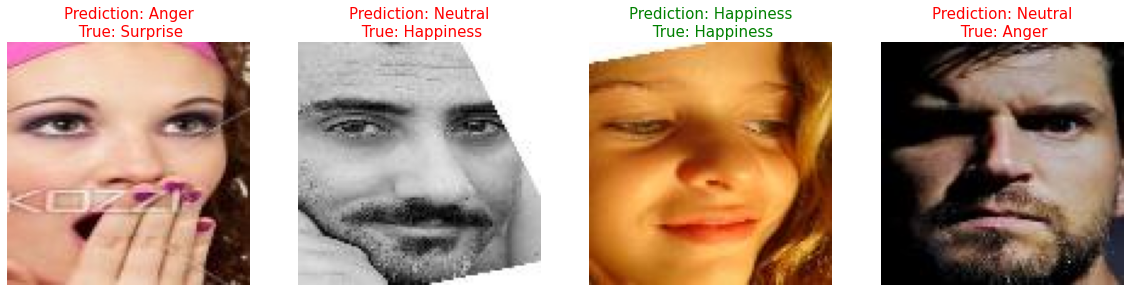

In [63]:
EmotionRecognition(TEST_FOLDER,"rsvm")


Then, make a call to the `EmotionRecognition` function to see what results it produces. You must also indicate the syntax needed to test your different models.

This isnt a model, please enter again


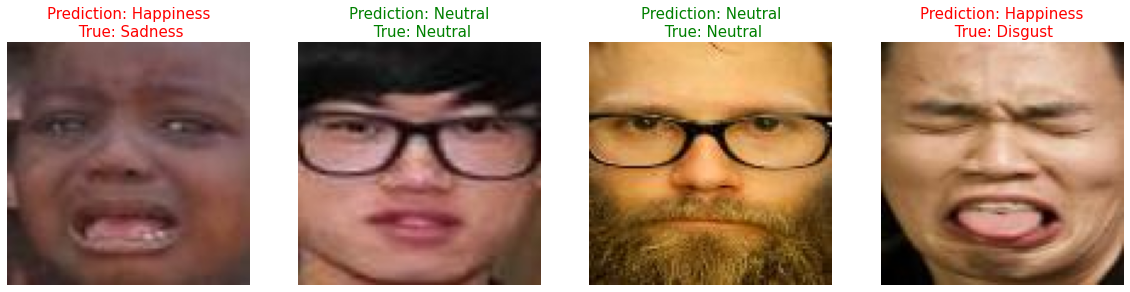

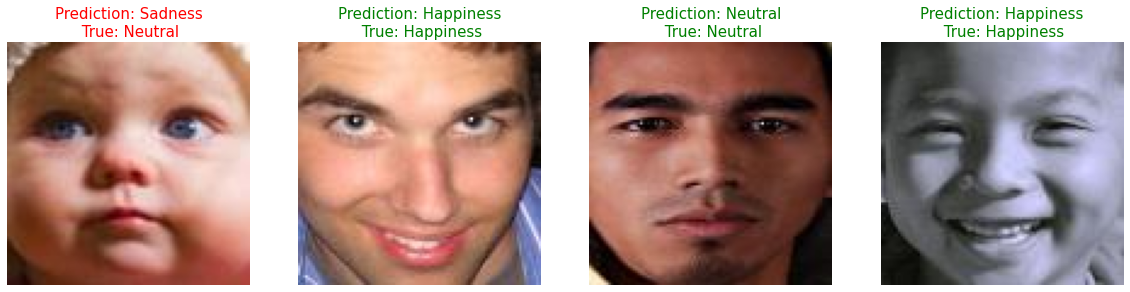

In [64]:
# Syntax for the next function is the following:
# 
# EmotionRecognition(path_to_testset, model_type)
# 
# where model_type can be one of
#   - rf
#   - rsvm
#   - cnn

path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')
EmotionRecognition(path_to_testset, 'hog-svm')
EmotionRecognition(TEST_FOLDER,"cnn")
EmotionRecognition(TEST_FOLDER,"rf")



# Test EmotionRecognition in the wild

This section should allow a quick test of the `EmotionRecognition` on your `Personal_Dataset`.

In [ ]:
# Syntax for the next function is the following:
# 
# EmotionRecognition(path_to_testset, model_type)
# 
# where model_type can be one of
#   - rf
#   - rsvm
#   - cnn

path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
EmotionRecognition(path_to_testset, 'cnn')
EmotionRecognition(path_to_testset, 'rf')
EmotionRecognition(path_to_testset, 'rsvm')